## Code to start on Q2 RL milestone
*Milestone text:* Developed a trainable reinforcement learning strategy for building organic molecules. Leveraged existing radical database to train a generative model that results in at least 50 novel molecules with high similarity to the training database. Novelty was assessed computationally using RDKit’s SMILES canonicalization procedure, and similarity was validated using Tanimoto similarity of molecular fingerprints, ensuring all molecules have a similarity of at least 0.7 to existing calculations.

In [1]:
import pandas as pd

import rdkit
from rdkit import Chem
from rdkit import DataStructs

import numpy as np
from tqdm import tqdm

rng = np.random.default_rng(1)
tqdm.pandas()

/projects/rlmolecule/pstjohn/envs/tf2_gpu/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
radicals = pd.read_csv('radicals.csv.gz')['0']
radicals.sample(5)

68598     CC[C@](C)([C]=O)C(N)=O
305427      CNC[C@H]([O])c1ccco1
385745        [O]c1ccc(F)c(Br)c1
384181         OC1=CCc2c[c]ccc21
23909      Cc1[c]c[nH]c(=O)c1C#N
Name: 0, dtype: object

In [3]:
radicals.shape

(425725,)

We don't need this, but if we wanted to filter out a given element from the process we could check the elements in each radical with the following code:

In [4]:
# from collections import Counter

# def get_elems(smiles):
#     return pd.Series(Counter((
#         atom.GetSymbol() for atom in 
#         Chem.MolFromSmiles(smiles).GetAtoms())))

# elems = radicals.progress_apply(get_elems).fillna(0).astype(int)

In [5]:
import sys
sys.path.append('../molecule_builder')
from molecule_builder import build_molecules, get_free_valence, shuffle

In [6]:
def make_radical(starting_mol):
    """ For a given starting molecule, select atom randomly to make a
    radical where stereochem allows """
    for i, atom in shuffle(enumerate(starting_mol.GetAtoms())):
        if get_free_valence(atom) > 0:
            rw_mol = Chem.RWMol(starting_mol)
            rw_mol.GetAtomWithIdx(3).SetNumRadicalElectrons(1)
            yield rw_mol   

            
def build_radical(mol, num):
    """ Just builds a large molecule """
    for mol in build_molecules(
        mol, stereoisomers=False,
        atom_additions=('Br', 'C', 'N', 'O', 'S', 'P', 'Cl', 'F')):
        
        if num == 1:  # num counts down, this is the final molecule
            yield from make_radical(mol)
            
        else:
            yield from build_radical(mol, num=num-1)

            
def build_random(low, high):
    return next(build_radical(rdkit.Chem.MolFromSmiles('C'),
                              rng.integers(low=low, high=high, endpoint=True)))

In [7]:
# This step, pre-calculating fingerprints for the radical database,
# is slow but only has to be done once per evaluation
radical_fps = radicals.progress_apply(lambda x: Chem.RDKFingerprint(Chem.MolFromSmiles(x)))

  3%|▎         | 11843/425725 [00:03<01:59, 3475.63it/s]RDKit WARNING: [18:19:32] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [18:19:32]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [18:19:32] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [18:19:32]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [18:19:32] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [18:19:32]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [18:19:32] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [18:19:32]   BondStereo set to STEREONONE and single bond directions set to NONE.
 74%|███████▎  | 313585/425725 [00:45<00:13, 8298.70it/s] RDKit WARNING: [18:20:14] Conflicting single bond directions around double bond at index 2.
RDKit WARNING: [18:20:14]   BondStereo

In [8]:
radical_set = set(radicals)

def evaluate_max_similarity(target_mol):
    """ This is the function we'll need to maximize. At least find new molecules
    that are < 1; but greater than 0.7 """
    
    if target_mol in radical_set:
        return 1.  
        # zero? We don't want this necessarily, but at the same time
        # don't want to penalize building realistic molecules
    
    # Precalculate the fingerprint for the target molecule
    target_fp = Chem.RDKFingerprint(target_mol)

    # This is surprisingly fast, ~1 second on an Eagle node. I tried
    # multiprocessing.pool, but we'd likely want to batch the fingerprints
    # since the overhead is likely higher than the gains from parallelizing
    # individually
    max_similarity = radical_fps.apply(
        lambda x: DataStructs.FingerprintSimilarity(x, target_fp)).max()
    
    return max_similarity

In [10]:
%timeit evaluate_max_similarity(next(build_radical(rdkit.Chem.MolFromSmiles('C'), 5)))

925 ms ± 7.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

Here I just take a look at the distribution in similarities from some randomly built molecules

100%|██████████| 200/200 [03:06<00:00,  1.07it/s]


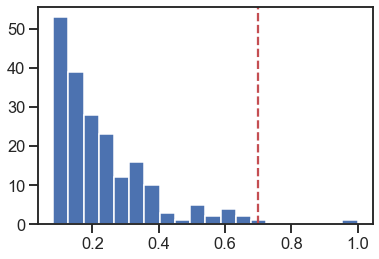

In [12]:
similarities = [evaluate_max_similarity(build_random(4, 8)) for _ in tqdm(range(200))]

plt.hist(np.array(similarities), bins=20)
plt.axvline(x=0.7, ls='--', color='r')

We may not have to much better than random guessing to find our 50. Would also be cool to include some of Rob's synthetic accessibility scores in these assessments as well, since I'm sure these molecules are garbage (just thrown together atoms, only respecting valency rules)